# Automated Health Risk Pipeline Analysis

In [6]:
# Libraries
import pandas as pd
from datetime import datetime
from helper_functions import *
import warnings
warnings.filterwarnings("ignore")
from Scoring import *
import matplotlib.pyplot as plt

In [ ]:
# To be filled (Input #1)

# Path to raw full data
full_dataset_path = r"C:\Frank\UoT 2024-2025\MIE8888 Project\full_dataset_2.11.csv"

In [ ]:
# Preprocessing Data and conduct risk score for each treatment
'''
If the procedure code is 4 digits long:  
Codes starting with 1 or 2 are assigned a risk level of 0.5.  
Codes starting with 3, 4, or 5 are assigned a risk level of 0.  


If the procedure code is 5 digits long, risk levels are assigned based on the first digit:  
Codes starting with 1 get a risk level of 1.  
Codes starting with 2 to 8 have negative risk levels, decreasing incrementally.  
Codes starting with 9 or any other number get a risk level of 0.  
'''

# Load and preprocess dataset
results = pd.read_csv(full_dataset_path, encoding="Windows-1252")

# Calculate patient age at procedure date
results['procedure_date'] = pd.to_datetime(results['procedure_date'], errors='coerce')
results['birth_date'] = pd.to_datetime(results['birth_date'], errors='coerce')
results['age'] = results['procedure_date'].dt.year - results['birth_date'].dt.year
results = results[results['age'] >= 0]  # Remove invalid rows

# Convert and clean date columns
results['first_visit'] = pd.to_datetime(results['first_visit'], errors='coerce')
results[['first_visit', 'procedure_date']] = results[['first_visit', 'procedure_date']].apply(lambda col: col.dt.tz_localize(None))

# Calculate time between first visit and procedure
results['visit_procedure_diff'] = (results['procedure_date'] - results['first_visit']).dt.days
results = results[results['visit_procedure_diff'] >= 7 * 365]  # Keep patients with long histories

# Reset index and extract key dataframes
results.reset_index(drop=True, inplace=True)
treatment_df = results[['patient_id', 'patient', 'procedure_date', 'procedure_code_y']].copy()
patient_df = results[['patient_id', 'patient', 'birth_date', 'first_visit']].drop_duplicates()

# Apply risk level mapping
treatment_df['risk_level'] = treatment_df['procedure_code_y'].apply(assign_risk)

print('The treatment with risk level score being added as been completed')

The treatment with risk level score being added as been completed


,patient_id,patient,birth_date,first_visit
0,2479,EMMA KUNST,1939-01-21 00:00:00+00:00,1991-08-08
2,6970,NICK CICCONE,1961-03-12 00:00:00+00:00,1999-11-23
3,6239,PATTY CASTELLANO,1968-07-15 00:00:00+00:00,1998-04-14
4,3737,MARIA GUGLIELMI,1957-05-06 00:00:00+00:00,1993-10-13
7,5913,CHRISTINA WILSON,1935-10-26 00:00:00+00:00,1997-08-12
...,...,...,...,...
165957,7506,LISA GAO,1993-01-20 00:00:00+00:00,2001-04-11
166995,3079,MIGUEL CALDERON,1965-04-17 00:00:00+00:00,1992-09-29
167102,3536,VITO CISTERNINO,1953-09-17 00:00:00+00:00,2000-11-29
167188,6988,MICHAEL TATE,1947-08-18 00:00:00+00:00,1999-12-08


In [ ]:
# Run the scoring function (This process may take 30-45 mins to run based on current dataset)
result_df = compute_rolling_scores(treatment_df, patient_df)

# drop rows where the time to crowns/root canals are negative but keep the null values
health_scores_with_features_df_c = result_df[(result_df['time_to_crowns'] >= 0) | (result_df['time_to_crowns'].isnull())]
health_scores_with_features_df_c = result_df[(result_df['time_to_root_canal'] >= 0) | (result_df['time_to_root_canal'].isnull())]
health_scores_with_features_df_c.reset_index(drop=True, inplace=True)
unique_patient_ids = health_scores_with_features_df_c['patient_id'].unique()
print('Health scores have been added successfully. One can use the unique patient ids to check the distribution his/her health score change over years')
unique_patient_ids

,patient_id,year,health_score,time_to_crowns,time_to_root_canal,recency_score,visit_frequency,average_risk_level,num_visits,polishing,...,retrofill_mandibular_molar,perforations_nonsurgical,perforations_surgical,open_and_drain,crowns,root_canals,starts_with_4_procedures,starts_with_5_procedures,starts_with_6_procedures,starts_with_7_procedures
0,2479,1999,0.98,NaN,NaN,0.700000,0.7,0.666667,3,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2479,2000,0.30,NaN,603.0,0.633333,1.0,0.111111,9,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,2479,2001,0.80,NaN,238.0,0.481818,1.0,0.181818,11,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,2479,2002,-0.85,NaN,NaN,0.500000,1.0,-0.107143,14,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,2479,2003,-1.15,NaN,NaN,0.546154,1.0,-0.115385,13,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83913,6696,2020,0.00,NaN,NaN,0.000000,0.5,0.000000,0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
83914,6696,2021,0.00,NaN,NaN,0.000000,0.5,0.000000,0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
83915,6696,2022,0.00,NaN,NaN,0.000000,0.5,0.000000,0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
83916,6696,2023,0.00,NaN,NaN,0.000000,0.5,0.000000,0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# To be filled (Input #2) One could check `unique_patient_ids` for available codes
patient_id = 2479

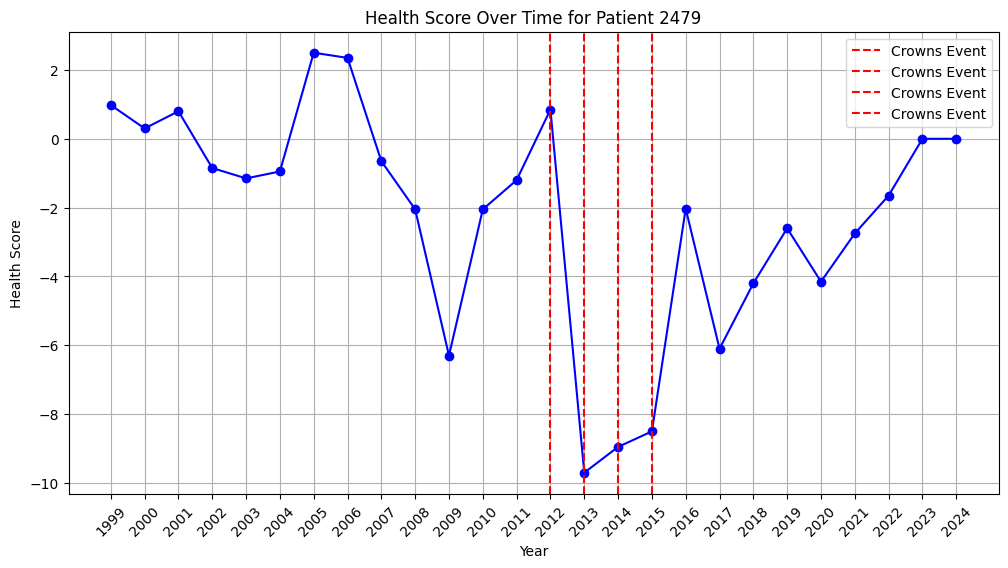

In [ ]:
# Click to plot the distribution
patient_health_scores = health_scores_with_features_df_c[health_scores_with_features_df_c['patient_id'] == patient_id]
plt.figure(figsize=(12, 6))
plt.plot(patient_health_scores['year'], patient_health_scores['health_score'], marker='o', color='b')
plt.title(f'Health Score Over Time for Patient {patient_id}')
plt.xlabel('Year')
plt.ylabel('Health Score')

# Add vertical lines for crown events
crowns_events = patient_health_scores[patient_health_scores['time_to_crowns'].notnull()]
for _, event in crowns_events.iterrows():
    plt.axvline(event['year'], color='r', linestyle='--', label='Crowns Event')

plt.xticks(patient_health_scores['year'].unique(), rotation=45)
plt.legend()
plt.grid(True)
plt.show()